# LWW Element Graph Demo

The purpose of this demo is to show how to use the LWWElementGraph class and give an example showing it working.

In [1]:
from lwwelementgraph import LWWElementGraph

# needed because LWWElementGraph is based on LWWElementSet
from lwwelementset import LWWElementSet

# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# library for visualising graphs
import networkx as nx

# time library
import datetime

In [2]:
def convert_LWWElementGraph_to_nx(g, timestamp):
    """
    convert an LWWElementGraph at timestamp to a networkx graph object for plotting
    """
    G = nx.Graph()
    
    for v in g.vertices.addSet:
        if g.hasVertex(v[0], timestamp):
            G.add_node(v[0])
            
    for e in g.edges.addSet:
        if g.hasEdge(e[0], timestamp):
            edge_list = list(e[0])
            if len(edge_list) == 1:
                G.add_edge(edge_list[0], edge_list[0])
            else:
                G.add_edge(edge_list[0], edge_list[1])
            
    return G

## Plotting Example

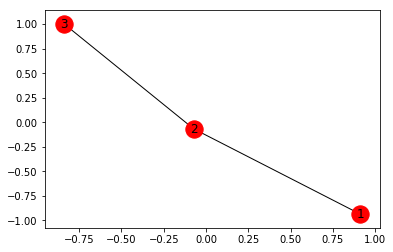

In [3]:
vertices = LWWElementSet(set([]), set([]))
edges = LWWElementSet(set([]), set([]))

# set up a LWWElementGraph object
g = LWWElementGraph(vertices, edges)

# add vertices at timestamp 0
g.addVertex(1, 0)
g.addVertex(2, 0)
g.addVertex(3, 0)

# add edges at timestamp 0
g.addEdgeBetween(1, 2, 0)   
g.addEdgeBetween(2, 3, 0)

# plot it
G = convert_LWWElementGraph_to_nx(g, 0)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
plt.show()

## Example of two LWW Element Graphs being edited concurrently

The timestamps can come from any ordered set. In the unit tests they are integers. Usually I expect they will be times. In this example, they are pandas timestamp objects.

In [4]:
# set up graphs
France = LWWElementGraph(LWWElementSet(set([]), set([])), LWWElementSet(set([]), set([])))
Germany = LWWElementGraph(LWWElementSet(set([]), set([])), LWWElementSet(set([]), set([])))

In [5]:
def now(): 
    return pd.to_datetime(datetime.datetime.now())

In [6]:
# add some vertices to France and Germany
France.addVertex('Paris', now())
Germany.addVertex('Berlin', now())
France.addVertex('Tours', now())

# add an edge
France.addEdgeBetween('Tours', 'Paris', now())

# add some more vertices
Germany.addVertex('Aachen', now())
Germany.addVertex('Bonn', now())
Germany.addVertex('Cologne', now())

# add an edge
Germany.addEdgeBetween('Cologne', 'Bonn', now())

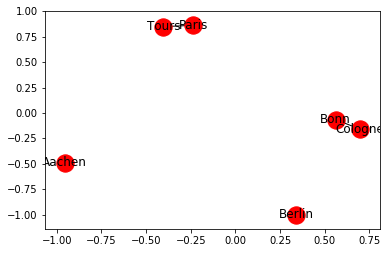

In [7]:
def plot_LWWElementGraph(g, timestamp):
    
    G = convert_LWWElementGraph_to_nx(g, timestamp)
    
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
    plt.show()
    
# plot the merged graph
plot_LWWElementGraph(Germany.merge(France), now())

In [8]:
# France adds a connection to Germany
France.addVertex('Bonn', now())
France.addEdgeBetween('Paris', 'Bonn', now())

# Germany adds a connection to France
Germany.addVertex('Paris', now())
Germany.addEdgeBetween('Paris', 'Berlin', now())

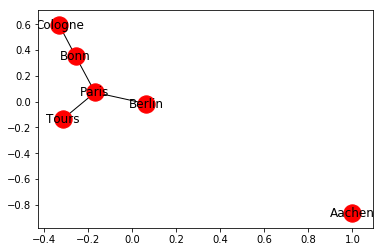

In [9]:
plot_LWWElementGraph(Germany.merge(France), now())

Note that France is able to remove `Aachen` even though France has not yet added `Aachen` to the France graph. The deletion has an effect on the merged graph but not on the France graph or the Germany graph.

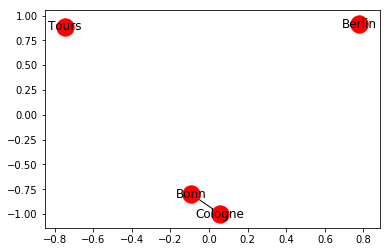

In [10]:
# removing vertices
Germany.removeVertex('Paris', now())
France.removeVertex('Aachen', now())

plot_LWWElementGraph(Germany.merge(France), now())

It is possible to add a vertex back in which was removed by someone else.

France adds `Paris` back into the graph and `Paris` now appears in the merged graph because France is the last writer.

The edges between Paris, Tours and Bonn still exist in the France graph. However, the edge between Paris and Berlin no longer appears in the merged graph because it existed only in the Germany graph and was deleted when Germany deleted Paris

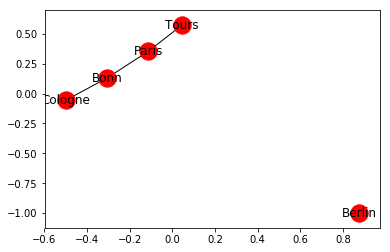

In [11]:
# adding a vertex back in which was removed by someone else
France.addVertex('Paris', now())

# Paris in now in the merged graph again, because France is the last writer

# the edges between Paris, Tours and Bonn still exist in the France graph. However, the edge between
# Paris and Berlin has been deleted because it existed only in the Germany graph and was
# deleted when Germany deleted Paris

plot_LWWElementGraph(Germany.merge(France), now())

In [12]:
# France attempts to add an edge between Paris and Cologne, but cannot because Cologne does not exist
# in the France graph
France.addEdgeBetween('Paris', 'Cologne', now())

NonExistentVertex: Cannot add edge if not all endpoints exist.

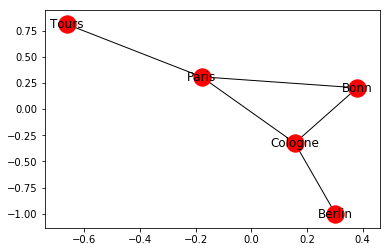

In [13]:
France.addVertex('Cologne', now())
France.addEdgeBetween('Paris', 'Cologne', now())
Germany.addEdgeBetween('Berlin', 'Cologne', now())

plot_LWWElementGraph(Germany.merge(France), now())

It is possible to delete a vertex which does not exist in your own copy of the graph. For example, here Germany deletes `Tours` 

In [14]:
# Note that Germany does not contain Tours
Germany.hasVertex('Tours', now())

False

In [15]:
# However, Germany can still delete the vertex (I'm not sure whether this is desired behaviour)
Germany.removeVertex('Tours', now())

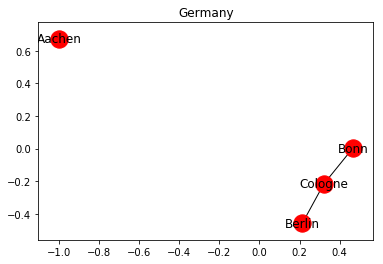

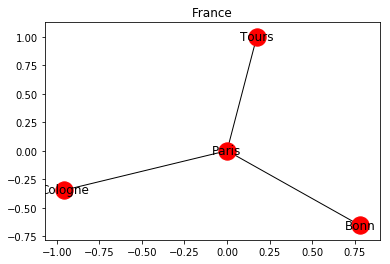

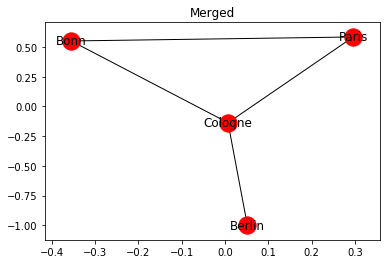

In [16]:
# the Tours vertex has now disappeared from the merged graph
# Aachen has also disappeared because France deleted it a while ago
plt.title('Germany')
plot_LWWElementGraph(Germany, now())

plt.title('France')
plot_LWWElementGraph(France, now())

plt.title('Merged')
plot_LWWElementGraph(Germany.merge(France), now())

In [17]:
# find the set of vertices connected to Cologne
Germany.merge(France).findAllVerticesConnectedTo('Cologne', now())

{'Berlin', 'Bonn', 'Paris'}

In [18]:
# see if there is a path between Tours and Bonn in the France graph
France.findAnyPathBetweenTwoVertices('Tours', 'Bonn', now())

True